In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


##Teste

In [17]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.patches import cv2_imshow
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import os
import numpy
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_lfw_people
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Função read_images que irá pegar a pasta passada e o tamanho desejado de imagem e retornará os nomes, o vetor de imagens a serem utilizadas e um vetor com as labels

In [18]:
def read_images(path, image_size):
  names = []
  training_images, training_labels = [], []
  label = 0
  for dirname, subdirnames, filenames in os.walk(path):
    for subdirname in subdirnames:
        names.append(subdirname)
        subject_path = os.path.join(dirname, subdirname)
        for filename in os.listdir(subject_path):
          img = cv2.imread(os.path.join(subject_path, filename), cv2.IMREAD_GRAYSCALE)
          if img is None:
            # The file cannot be loaded as an image.
            # Skip it.
            continue
          img = cv2.resize(img, image_size)
          training_images.append(img)
          training_labels.append(label)
        label += 1
  training_images = numpy.asarray(training_images, numpy.uint8)
  training_labels = numpy.asarray(training_labels, numpy.int32)
  #print(training_images.shape)
  return names, training_images, training_labels

#Nessa célula será salvo a pasta com as imagens, o tamanho final das imagens e será chamada a função read_images

In [19]:
path_to_training_images = '/content/gdrive/MyDrive/Dataset'
training_image_size = (120, 120)
names, training_images, training_labels = read_images(path_to_training_images, training_image_size)

#Print responsável por verificar o conjunto de nomes e o vetor que contem as training labels, mais para a frente do programa será comparado o training_labels com o valor de predição

In [20]:
print(names , training_labels)

['Joao Luiz', 'Vinicius', 'Elton', 'alba'] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3]


#Mostrando um exemplo 

<class 'numpy.ndarray'>
(120, 120)
['Joao Luiz', 'Vinicius', 'Elton', 'alba']


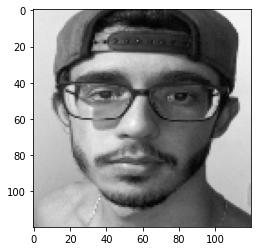

In [21]:
plt.imshow(training_images[14], cmap='gray')
print(type(training_images[0]))
print(training_images[0].shape)
print(names)

#Para predição das imagens foi necessário da um reshape

In [22]:
#nsamples, nx, ny = train_dataset.shape
#d2_train_dataset = train_dataset.reshape((nsamples,nx*ny))
nsamples_i, nx_i, ny_i = training_images.shape
d2_training_images = training_images.reshape((nsamples_i, nx_i*ny_i))

#Utilizando PCA para analizar os componentes principais das fotos e armazenando, modelo utilizado é o SVM não linear

(68, 14400)
(68, 20)


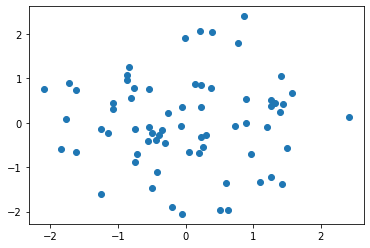

In [29]:
from sklearn.decomposition import PCA
#pca = PCA(n_components=2)

pca = PCA(n_components=20, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

print(d2_training_images.shape)
pca_images = pca.fit_transform(d2_training_images)
print(pca_images.shape)
plt.scatter(pca_images[:,0], pca_images[:,1])

#Separando modelo de treino e teste

In [9]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(training_images, training_labels, random_state=10)

#Utilizando cálculo de peso (gama e C) para treinar o modelo 

In [30]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50], 'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(pca_images, training_labels)
print(grid.best_params_)

CPU times: user 435 ms, sys: 679 µs, total: 436 ms
Wall time: 440 ms
{'svc__C': 5, 'svc__gamma': 0.005}


#Mostrando a quantidade de imagens do Dataset


In [25]:
training_labels.size

68

#Predizendo os valores de pca

In [31]:
model = grid.best_estimator_
yfit = model.predict(pca_images)
print(names)
print(training_labels)
print(yfit)

['Joao Luiz', 'Vinicius', 'Elton', 'alba']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3]


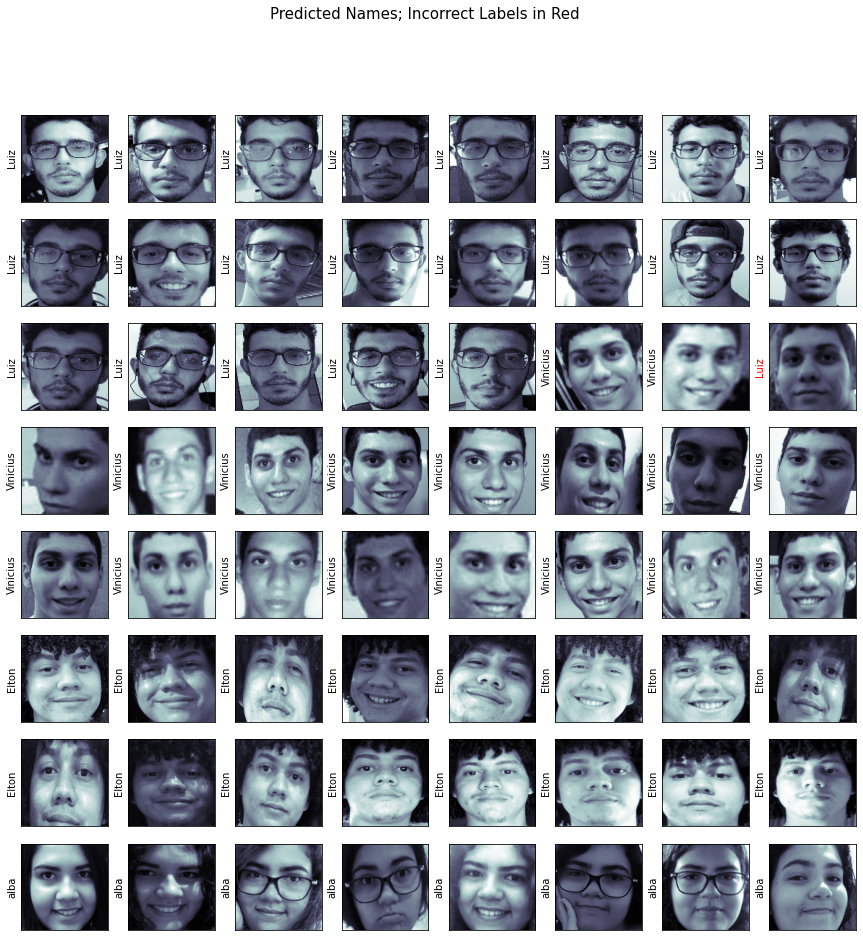

In [32]:
fig, ax = plt.subplots(8, 8, figsize = (15,15))
for i, axi in enumerate(ax.flat):
    axi.imshow(training_images[i].reshape(120, 120), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(names[yfit[i]].split()[-1], color='black' if yfit[i] == training_labels[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=15);

In [33]:
from sklearn.metrics import classification_report
print(classification_report(training_labels, yfit,target_names = names))

              precision    recall  f1-score   support

   Joao Luiz       0.95      1.00      0.98        21
    Vinicius       1.00      0.95      0.97        19
       Elton       1.00      1.00      1.00        16
        alba       1.00      1.00      1.00        12

    accuracy                           0.99        68
   macro avg       0.99      0.99      0.99        68
weighted avg       0.99      0.99      0.99        68

